In [325]:
import matplotlib.pyplot as plt
import lcapy
import ltparse

#make matplotlib hires
%config InlineBackend.figure_format='retina'

In [ ]:
lt = LTspice()
lt.read(path + name)
lt.parse()
lt.make_netlist()
print(lt.netlist)
lt.plot_nodes()
cct=lt.circuit()
cct.draw()

In [328]:
component_offsets = {
    # each entry has x_off, y_off, and length
    'voltage': [0, 16, 96],
    'cap': [16, 0, 64],
    'res': [16, 16, 96],
    'current': [0, 0, 80],
    'polcap': [16, 0, 64],
    'ind': [16, 16, 96],
}


def node_key(x, y):
    """Cast LTspice x,y location to a key for a dictionary."""
    return "%05d_%05d" % (10000+int(x), 10000+int(y))


def the_direction(line):
    """Determine the direction of the two nodes."""
    x1 = int(line[1])
    y1 = int(line[2])
    x2 = int(line[3])
    y2 = int(line[4])

    if x1==x2:
        if y1 > y2:
            return 'up'
        return 'down'

    if x1 > x2:
        return 'left'

    return 'right'


def ltspice_value_to_number(s):
    """Convert LTspice value 4.7k to 4700."""
#    print("converting ", s)
    # sometimes "" shows up as the value
    empty = pp.Literal('""')
    try:
        empty.parseString(s)
        return ''
    except pp.ParseException:
        pass

    # return things like {R} untouched
    parameter = pp.Combine('{' + pp.restOfLine())
    try:
        parameter.parseString(s)
        return s
    except pp.ParseException:
        pass

    # this does not handle 1e-3
    number = pp.Combine(pp.Optional('.') + pp.Word(pp.nums) +
                        pp.Optional('.' + pp.Optional(pp.Word(pp.nums))))

    # the SI prefixes
    prefix = pp.CaselessLiteral('MEG') | pp.CaselessLiteral('F') | pp.CaselessLiteral('P') \
             | pp.CaselessLiteral('N') | pp.CaselessLiteral('U') | pp.CaselessLiteral('M') \
             | pp.CaselessLiteral('K')

    # use restOfLine to discard possible unwanted units
    lt_number = number + pp.Optional(prefix) + pp.restOfLine()

    try:
        parsed = lt_number.parseString(s)
        x = float(parsed[0])

        # change number based on unit prefix
        if parsed[1] == 'F':
            x *= 1e-15
        elif parsed[1] == 'P':
            x *= 1e-12
        elif parsed[1] == 'N':
            x *= 1e-9
        elif parsed[1] == 'U':
            x *= 1e-6
        elif parsed[1] == 'M':
            x *= 1e-3
        elif parsed[1] == 'K':
            x *= 1e3
        elif parsed[1] == 'MEG':
            x *= 1e6
        return x
    except pp.ParseException:
        pass

    return s

class LTspice():
    """Class to convert LTspice files to lcapy circuits."""
    def __init__(self):
        """Initialization object variables."""
        self.contents = None
        self.parsed = None
        self.nodes = None
        self.netlist = None

    def read(self, filename):
        """Read a file as contents."""
        try:
            with open(filename, 'r', encoding='utf-16-le') as f:
                self.contents = f.read()
        except UnicodeError:
            with open(filename, 'r', encoding='mac-roman') as f:
                self.contents = f.read()


    def parse(self):
        """Parse LTspice .asc file contents."""
        heading = pp.Group(pp.Keyword("Version") + pp.Literal("4"))
        integer = pp.Combine(pp.Optional(pp.Char('-')) + pp.Word(pp.nums))
        label = pp.Word(pp.alphanums + '_')
        sheet = pp.Group(pp.Keyword("SHEET") + integer * 3)
        rotation = pp.Group(pp.Char("R") + integer)
        wire = pp.Group(pp.Keyword("WIRE") + integer * 4)
        window = pp.Group(pp.Keyword("WINDOW") + pp.restOfLine())
        symbol = pp.Group(pp.Keyword("SYMBOL") + label + integer*2 +
                          rotation)
        attr = pp.Group(pp.Keyword("SYMATTR") + label + pp.White() +
                        pp.restOfLine())
        flag = pp.Group(pp.Keyword("FLAG") + integer * 2 + label)
        iopin = pp.Group(pp.Keyword("IOPIN") + integer * 2 + label)
        text = pp.Group(pp.Keyword("TEXT") + pp.restOfLine())
        line = pp.Group(pp.Keyword("LINE") + pp.restOfLine())
        rect = pp.Group(pp.Keyword("RECTANGLE") + pp.restOfLine())

        component = pp.Group(symbol + pp.Dict(pp.ZeroOrMore(window)) +
                             pp.Dict(pp.ZeroOrMore(attr)))
        linetypes = wire | flag | iopin | component | line | text | rect

        grammar = heading + sheet + pp.Dict(pp.ZeroOrMore(linetypes))
        self.parsed = grammar.parseString(self.contents)

    def print_parsed(self):
        """Better visualization of parsed LTspice file."""
        if self.parsed is None:
            print('Nothing parsed yet.')

        for line in self.parsed:
            element = line[0]

            if isinstance(element, pp.ParseResults):
                print(line[0])
                for i in range(1, len(line)):
                    print('    ', line[i])
                continue
            print(element, line[1:])

    def sort_nodes(self):
        """Sorts the notes a dict with nodes sorted."""
        sorted_keys = sorted(self.nodes)
        
        grounds = 0
        for key in sorted_keys:
            if self.nodes[key] == 0:
                grounds += 1
       
        count = 1
        for key in sorted_keys:
            if self.nodes[key] != 0:
                self.nodes[key] = count
                count += 1

    def print_nodes(self):
        """Prints the notes a dict with nodes sorted."""
        for key in self.nodes:
            print(key,' : ', self.nodes[key])

    def plot_nodes(self):
        """Plots the notes a dict with nodes sorted."""
        miny = 1e6
        maxy = -1e6
        plt.figure(figsize=(12,8))
        for key in self.nodes:
            x, y = key.split('_')
            xx = int(x)
            yy = int(y)

            miny = min(yy, miny)
            maxy = max(yy, maxy)

            plt.plot([xx], [yy], 'ob', markersize=3)
            plt.text(xx, yy, self.nodes[key], ha='center', va='bottom')
        plt.ylim(maxy+0.1*(maxy-miny), miny-0.1*(maxy-miny))
        plt.show()


    def make_nodes_from_wires(self):
        """Return dictionary of nodes."""
        self.nodes = {}

        # create all the ground nodes
        for line in self.parsed:
            if line[0] == 'FLAG' and line[3] == '0':
                n1 = node_key(line[1], line[2])
                if n1 not in self.nodes:
                    self.nodes[n1] = 0
        
        # now wire nodes
        for line in self.parsed:
            element = line[0]
            if element != 'WIRE':
                continue

            n1 = node_key(line[1], line[2])
            if n1 not in self.nodes:
                self.nodes[n1] = len(self.nodes)+1

            n2 = node_key(line[3], line[4])
            if n2 not in self.nodes:
                self.nodes[n2] = len(self.nodes)+1

    def wire_to_netlist(self, line):
        """Return netlist string for one wire in parsed data."""
        if line[0] != 'WIRE':
            return ''

        n1 = self.nodes[node_key(line[1], line[2])]
        n2 = self.nodes[node_key(line[3], line[4])]

        direction = the_direction(line)

        return 'W %d %d; %s\n' % (n1, n2, direction)

    def symbol_to_netlist(self, line):
        """Return netlist string for symbol in parsed data."""
        first = list(line[0])
        if first[0] != 'SYMBOL':
            return ''

        kind = first[1]
#        print("\nKind==", kind)
    
        x = int(first[2])
        y = int(first[3])

        rotation = list(first[4])[1]
        if rotation == '0':
            direction = 'down'
        elif rotation == '90':
            direction = 'left'
        elif rotation == '180':
            direction = 'up'
        else:
            direction = 'right'

        name = ''
        value = ''
        for sub_line in line:
            row = list(sub_line)

            if row[0] != 'SYMATTR':
                continue

            if row[1] == 'InstName':
                name = row[3]
                continue

            if row[1] == 'Value':
                value = row[3]
                continue

        node1, node2 = self.match_node(x, y, kind, direction)

        if value != '':
            value = ltspice_value_to_number(value)

        if kind=='current':
            direction += ', invert'

        if kind == 'polcap':
            direction += ', kind=polar, invert'

        return '%s %d %d %s; %s\n' % (name, node1, node2, value, direction)

    def make_netlist(self):
        """Process parsed LTspice data and create a simple netlist."""
        self.netlist = ''
        if self.parsed is None:
            self.parse()

        if self.nodes is None:
            self.make_nodes_from_wires()

        self.sort_nodes()
        self.print_nodes()

        for line in self.parsed:

            if line[0] == 'WIRE':
                self.netlist += self.wire_to_netlist(line)

            if isinstance(line[0], pp.ParseResults):
                self.netlist += self.symbol_to_netlist(line)

        self.netlist += ";autoground=True\n"


    def match_node(self, x, y, kind, direction):
        """Match ends of simple component to existing nodes."""
        x_off, y_off, length = component_offsets[kind]
#        print("Original %d %d %s x_off=%d y_off=%d length=%d" %
#              (x, y, direction, x_off, y_off, length))

        if direction == 'left':
            key1 = node_key(x-y_off, y+x_off)
            key2 = node_key(x-length, y+x_off)

        elif direction == 'right':
            key1 = node_key(x+y_off, y-x_off)
            key2 = node_key(x+length, y-x_off)

        elif direction == 'down':
            key1 = node_key(x+x_off, y+y_off)
            key2 = node_key(x+x_off, y+length)

        elif direction == 'up':
            key1 = node_key(x-x_off, y-y_off)
            key2 = node_key(x-x_off, y-length)

        if key1 not in self.nodes:
            n1 = '?'
        else:
            n1 = self.nodes[key1]

        if key2 not in self.nodes:
            n2 = '?'
        else:
            n2 = self.nodes[key2]

#        print("pt1 %s ==> %s" % (key1,n1))
#        print("pt2 %s ==> %s" % (key2,n2))

        return n1, n2

    def circuit(self):
        """Create a lcapy circuit."""
        if self.netlist is None:
            return None

        cct = lcapy.Circuit()
        for line in self.netlist.splitlines():
            cct.add(line)
        return cct

10032_10464  :  0
10144_10176  :  5
10032_10176  :  1
10320_10176  :  9
10224_10176  :  7
10576_10176  :  13
10672_10176  :  18
10848_10176  :  21
10752_10176  :  20
11040_10176  :  25
11136_10176  :  29
11296_10176  :  33
11200_10176  :  31
10032_10256  :  2
10320_10256  :  10
10576_10256  :  14
10848_10256  :  22
11040_10256  :  26
11296_10256  :  34
10032_10416  :  4
10032_10336  :  3
10144_10416  :  6
10320_10416  :  12
10320_10336  :  11
10224_10416  :  8
10576_10416  :  16
10576_10336  :  15
10656_10416  :  17
10848_10416  :  24
10848_10336  :  23
10736_10416  :  19
11040_10416  :  28
11040_10320  :  27
11136_10416  :  30
11296_10416  :  36
11296_10320  :  35
11200_10416  :  32


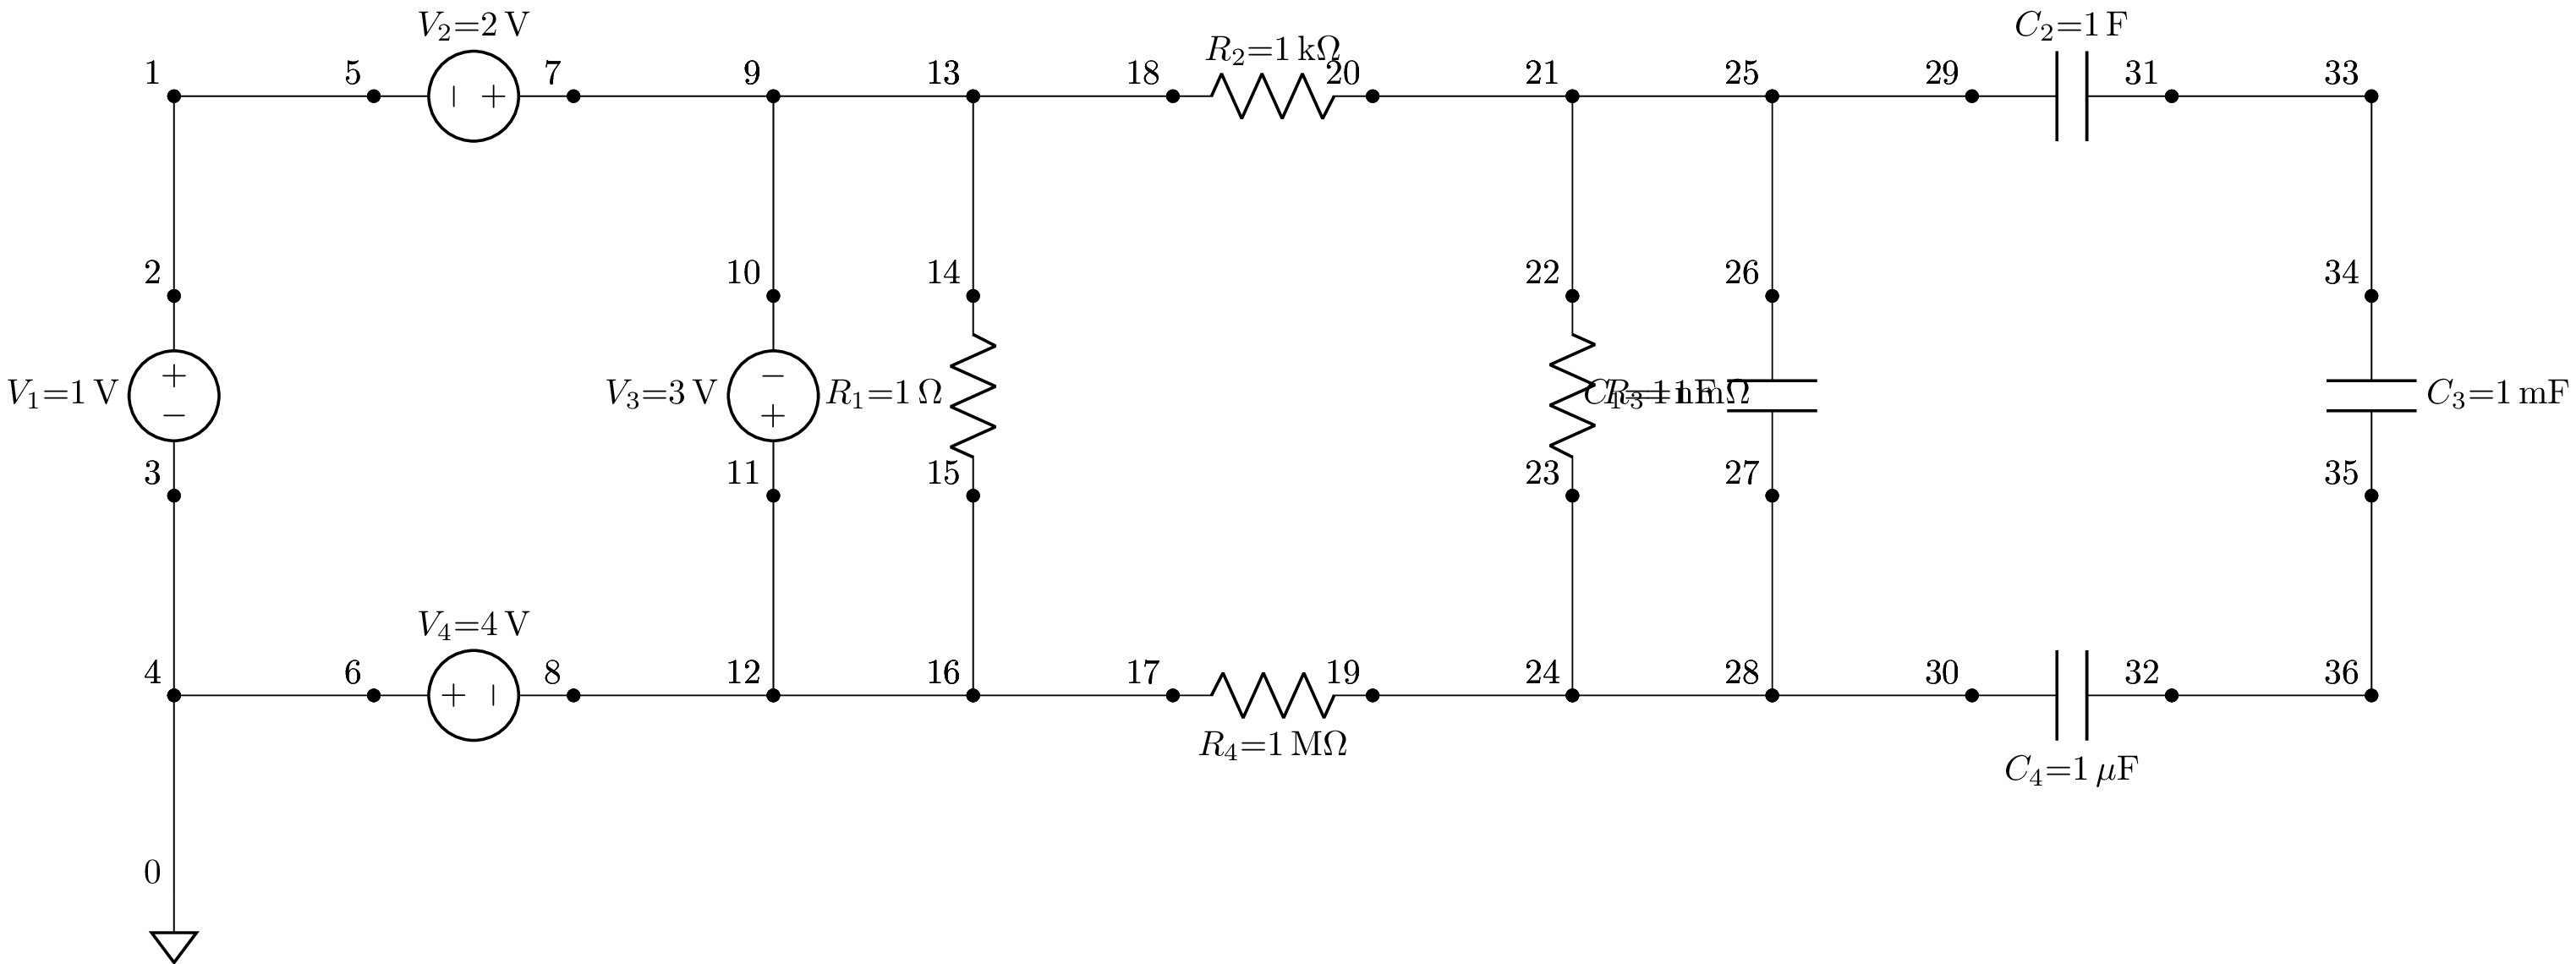

In [322]:
lt = LTspice()
lt.read("/Users/prahl/Desktop/orientation-test.asc")
lt.parse()
lt.make_netlist()
cct=lt.circuit()
cct.draw()

10032_10464  :  0
10144_10176  :  5
10032_10176  :  1
10320_10176  :  9
10224_10176  :  7
10576_10176  :  13
10672_10176  :  18
10848_10176  :  21
10752_10176  :  20
11040_10176  :  25
11136_10176  :  29
11296_10176  :  33
11200_10176  :  31
10032_10256  :  2
10320_10256  :  10
10576_10256  :  14
10848_10256  :  22
11040_10256  :  26
11296_10256  :  34
10032_10416  :  4
10032_10336  :  3
10144_10416  :  6
10320_10416  :  12
10320_10336  :  11
10224_10416  :  8
10576_10416  :  16
10576_10336  :  15
10656_10416  :  17
10848_10416  :  24
10848_10336  :  23
10736_10416  :  19
11040_10416  :  28
11040_10320  :  27
11136_10416  :  30
11296_10416  :  36
11296_10320  :  35
11200_10416  :  32


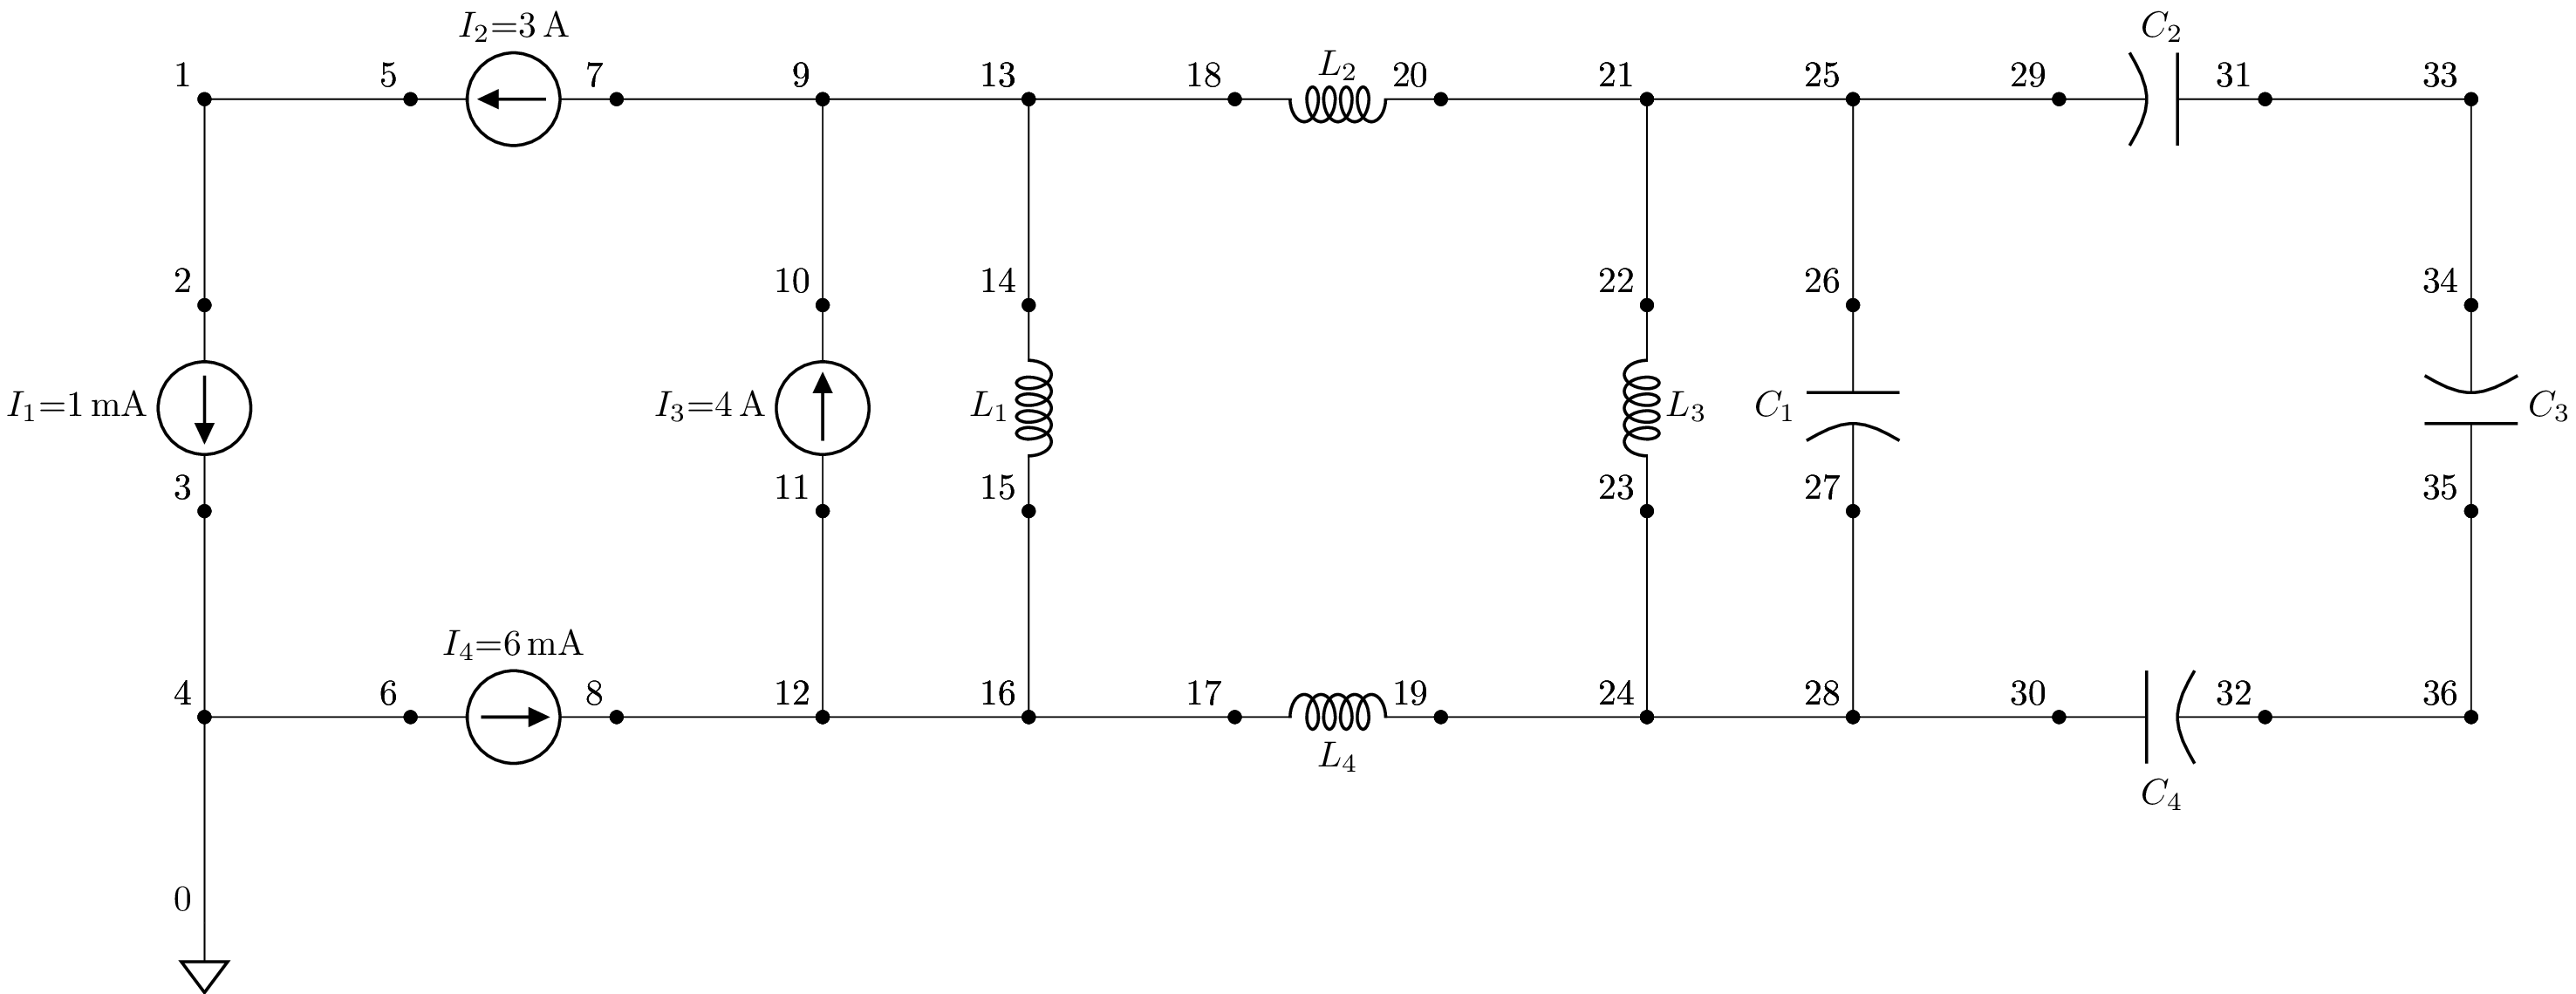

In [323]:
lt = LTspice()
lt.read("/Users/prahl/Desktop/orientation-test2.asc")
lt.parse()
lt.make_netlist()
cct=lt.circuit()
cct.draw()

09088_12208  :  0
08368_11984  :  0
10016_11776  :  0
08704_12032  :  0
10016_12224  :  0
08896_11648  :  15
08864_11648  :  12
08992_11648  :  18
09312_11648  :  26
09056_11648  :  19
09904_11648  :  37
10016_11648  :  41
09984_11648  :  39
10016_11680  :  42
09376_11712  :  28
09280_11712  :  24
10016_11760  :  43
09552_11856  :  33
09472_11856  :  31
08416_11872  :  4
08368_11872  :  1
08496_11872  :  5
08704_11872  :  9
08576_11872  :  6
08864_11872  :  13
08368_11888  :  2
08704_11920  :  10
09632_11968  :  35
09552_11968  :  34
08368_11968  :  3
08704_12000  :  11
08592_12064  :  7
08672_11984  :  8
08864_12096  :  14
08896_12096  :  16
08976_12096  :  17
09088_12096  :  21
09056_12096  :  20
09312_12096  :  27
09456_12096  :  30
09712_12096  :  36
09520_12096  :  32
09904_12096  :  38
10016_12096  :  44
09984_12096  :  40
09088_12112  :  22
10016_12128  :  45
09376_12160  :  29
09296_12160  :  25
09088_12176  :  23
10016_12208  :  46
W 15 12; left
W 18 15; left
W 26 19; left
W 3

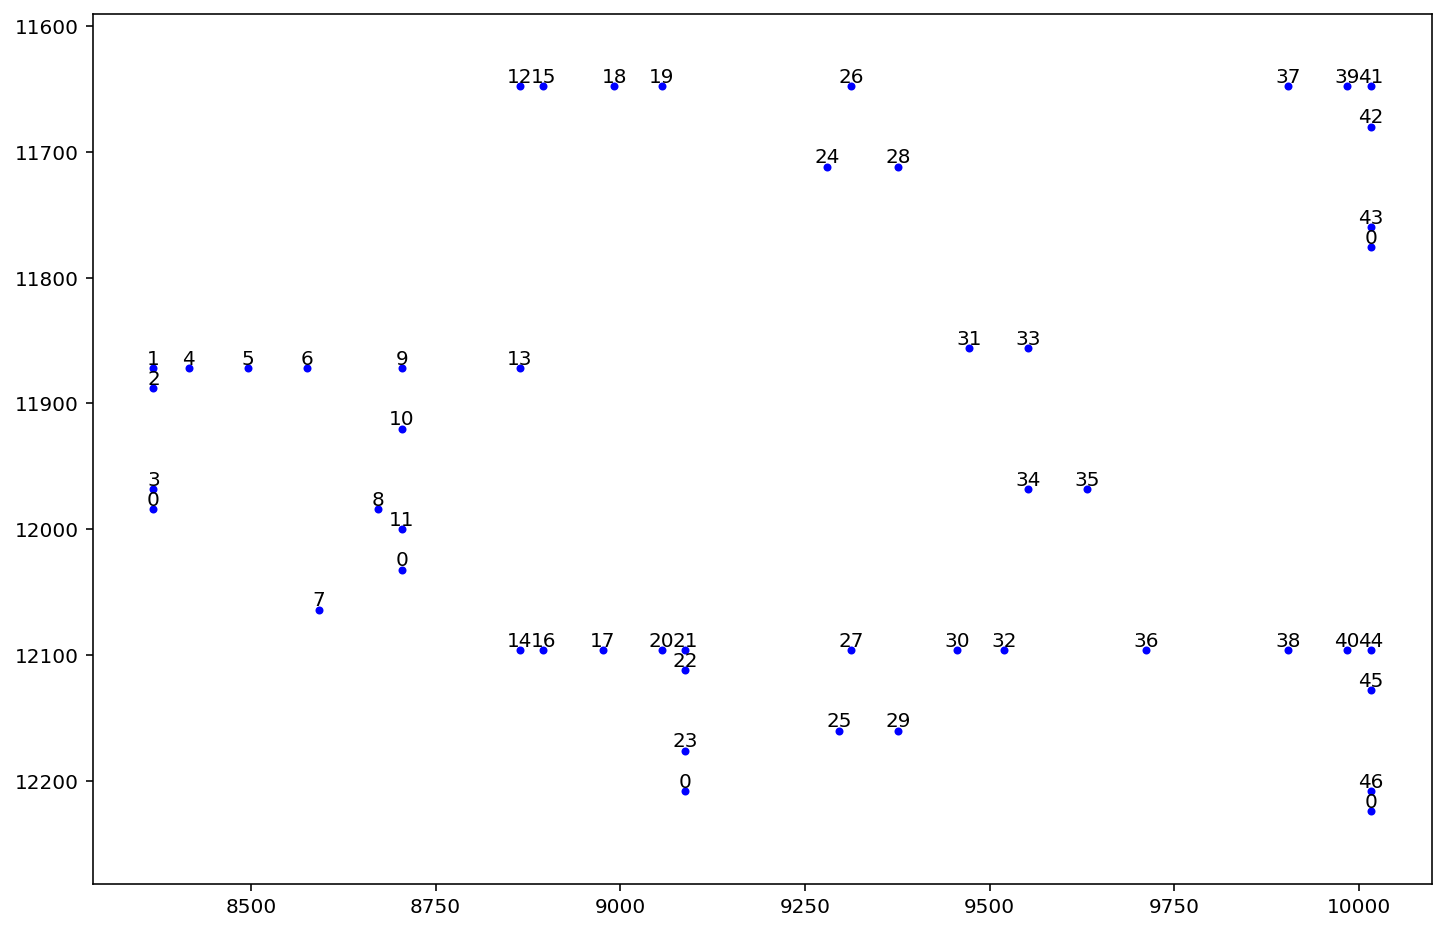

ValueError: Cannot assign nodes [('24',), ('28',), ('31',), ('33',), ('34',), ('35',), ('7',), ('8',), ('25',), ('29',)] for horizontal graph.
@11.0 (14, 13, 12) --1.0*--> (15)
@11.0 (14, 13, 12) --1.0*--> (16)
@0 (15) --1.0*--> (18)
@0 (18) --1.0*--> (19)
@0 (19) --1.0*--> (26)
@0 (26) --1.0*--> (37)
@0 (37) --1.0*--> (39)
@0 (39) --1.0*--> (42, 41, 0, 43)
@0 (42, 41, 0, 43) --0*--> end
@0 (24) --1.0*--> (28)
@0 (28) --0*--> end
@0 (31) --1.0*--> (33)
@0 (33) --0*--> end
@16.0 (2, 1, 0_split2, 3) --1.0*--> (4)
@15.0 (4) --1.0*--> (5)
@14.0 (5) --1.0*--> (6)
@13.0 (6) --1.0*--> (10, 9, 0_split3, 11)
@12.0 (10, 9, 0_split3, 11) --1.0*--> (14, 13, 12)
@0 (34) --1.0*--> (35)
@0 (35) --0*--> end
@0 (7) --1.0*--> (8)
@0 (8) --0*--> end
@10.0 (16) --1.0*--> (17)
@9.0 (17) --1.0*--> (20)
@8.0 (20) --1.0*--> (22, 21, 0_split4, 23)
@7.0 (22, 21, 0_split4, 23) --1.0*--> (27)
@6.0 (27) --1.0*--> (30)
@5.0 (30) --1.0*--> (32)
@4.0 (32) --1.0*--> (36)
@3.0 (36) --1.0*--> (38)
@2.0 (38) --1.0*--> (40)
@1.0 (40) --1.0*--> (45, 44, 0_split5, 46)
@0 (45, 44, 0_split5, 46) --0*--> end
@0 (25) --1.0*--> (29)
@0 (29) --0*--> end
@16.0 start --0*--> (24)
@16.0 start --0*--> (31)
@16.0 start --0*--> (2, 1, 0_split2, 3)
@16.0 start --0*--> (34)
@16.0 start --0*--> (7)
@16.0 start --0*--> (25)
@0 end


In [329]:
path = '/Users/prahl/Dropbox/OIT/225/Week 7/Audio Amp with Crossover (EE225 Demo)/'
name = 'Audio Amp with Crossover (EE225 Demo).asc'

lt = LTspice()
lt.read(path + name)
lt.parse()
lt.make_netlist()
print(lt.netlist)
lt.plot_nodes()
cct=lt.circuit()
cct.draw()